# Fitting
In this notebook, I'll show how to use `Korg.Fit.fit_spectrum` to fit one of the spectra from [Griffith et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221001821G).You will probably find it helpful to look at the [documentation for this function](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.fit_spectrum) as well. For fitting equivalent widths (rather than spectra directly) see [the documentation for `Korg.Fit.ews_to_abundances`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.ews_to_abundances).

This notebook is intended to domonstrate the usages of Korg's fitting functionality, not an ironclad spectral analysis.

We'll use a few packages in addition to Korg in this notebook.  If don't have them installed, you can run `using Pkg; Pkg.add(["CSV", "DataFrames", "PyPlot"])` to install them.

In [1]:
using Korg, CSV, DataFrames, PyPlot

[ Info: Precompiling Korg [acafc109-a718-429c-b0e5-afd7f8c7ae46]


## Read in the linelist, window list, and spectrum

For this example, we'll use the same linelist and windows as Griffith et al. 2022, which means reading the CSV files they are stored in and getting the data into the format expected by Korg.

In [2]:
# read and parse the linelist used by Griffith et al. 2022
linetable = CSV.read("lines.csv", DataFrame);
linelist = Korg.Line.(Korg.air_to_vacuum.(linetable.wave_A),
                      linetable.loggf,
                      Korg.Species.(linetable.element),
                      linetable.lower_state_eV,
                      linetable.rad, 
                      linetable.stark, 
                      linetable.waals) 
;

In [3]:
# read windows into dictionary that maps atomic number -> window list
windowtable = CSV.File("windows.tsv", delim='\t');
windows = Dict()
for row in windowtable
    # atomic number
    Z = Korg.get_atoms(Korg.Species(row.species))[1]
    # get the windows for this element so far 
    wins = get(windows, Z, [])
    # add the new window
    push!(wins, (Korg.air_to_vacuum(row.wave_base * 10), Korg.air_to_vacuum(row.wave_top * 10)))
    # update the dictionary
    windows[Z] = wins
end

In [4]:
# parse the observed spectrum
spec = CSV.read("2MASS_J03443498+0553014.csv", DataFrame)
spec.waveobs = Korg.air_to_vacuum.(spec.waveobs * 10)
;

# Get stellar params with just Fe lines
First, we'll use the Fe windows from `regions_list.txt` to fit for the stellar parameters. You may notice that the first time you run this, the `@time` macro reports a high fraction of time spent compiling.  This happens only once per session. 

In [5]:
# provide an initial guess for each parameter we want to fit
# (This is how to write a NamedTuple in Julia, by the way.)
initial_guess = (;Teff=5400, logg=3.8, m_H=-1.1, vmic=1.0)
winds = windows[26] # use Fe windows

# In this example, we'll pass the spectral resolution R and let Korg take care of the line spread function automatically
# Below, I'll show how to speed things up by calculating it ahead of time.
@time fit_result = Korg.Fit.fit_spectrum(spec.waveobs, spec.flux, spec.err, linelist, initial_guess; windows=winds, R=50_000)
;

Constructing LSF matrix 100%|████████████████████████████| Time: 0:00:16
[ Info: loading the model atmosphere grid into memory. This will take a few seconds, but will only happen once per julia session.


488.814755 seconds (540.48 M allocations: 213.354 GiB, 3.42% gc time, 78.17% compilation time: 0% of which was recompilation)


`fit_result` is an object containing several bits of info, most importantly the best-fit parameters

In [6]:
fit_result.best_fit_params

(Teff = 5260.553866351421, logg = 3.6957954595635325, m_H = -1.3314925063231198, vmic = 0.8265457230245863)

It also contains the trace, which we can plot like so

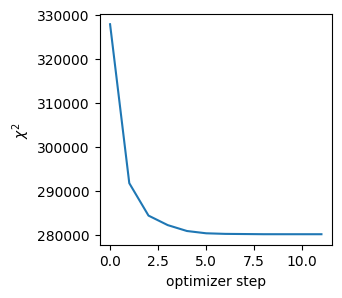

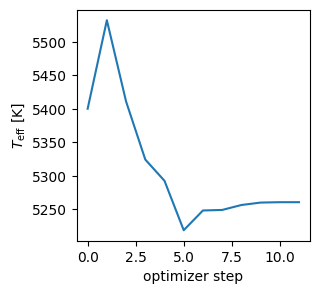

In [7]:
figure(figsize=(3,3))
plot([t.chi2 for t in fit_result.trace])
ylabel(L"χ^2")
xlabel("optimizer step")

figure(figsize=(3,3))
plot([t.Teff for t in fit_result.trace])
ylabel(L"$T_\mathrm{eff}$ [K]")
xlabel("optimizer step")
;

The `fit_result` object also contains the best-fit spectrum, which we can plot in comparision to the oberved one.  Rerun the cell below to plot data for different iron lines.

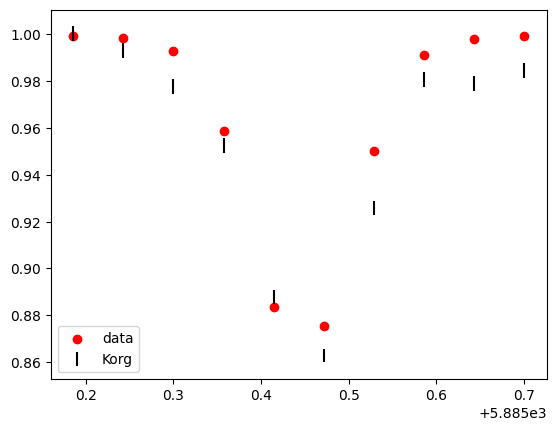

PyObject <matplotlib.legend.Legend object at 0x16805b210>

In [8]:
# get the observed spectrum only at the wavelengths within a fitting window
obs_wls = spec.waveobs[fit_result.obs_wl_mask]
obs_flux = spec.flux[fit_result.obs_wl_mask]
obs_err = spec.err[fit_result.obs_wl_mask]

w = rand(winds) # choose a window around a random Fe line

# create a bitmask to plot the window plus 1 Å on each side for context
mask = w[1]-1 .< obs_wls .< w[2]+1 

scatter(obs_wls[mask], fit_result.best_fit_flux[mask], c="r", label="data")
errorbar(obs_wls[mask], obs_flux[mask], yerr=obs_err[mask], ls="", c="k", label="Korg")
legend()

# Fit individual abundances
In this example, we'll calculate a matrix to apply the line-spead function ahead of time, saving the step of doing it for each fit.

In [9]:
# construct sparse matrix which simultaneously applies the LSF and downsamples to wavelengths of the observation
synthesis_wls = 4200:0.01:6350
LSF_matrix = Korg.compute_LSF_matrix(synthesis_wls, spec.waveobs, 50_000)
;

Constructing LSF matrix 100%|████████████████████████████| Time: 0:00:16


Let's use the stellar parameters from Griffith, rather than the ones from the analysis above. Comparing the abundances you get using each is left as an excercise to the reader.

In [10]:
griffith_params = (Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic=1.23)
println(fit_result.best_fit_params)
println(griffith_params)

(Teff = 5260.553866351421, logg = 3.6957954595635325, m_H = -1.3314925063231198, vmic = 0.8265457230245863)
(Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic = 1.23)


# find individual abundances

In [11]:
elements = ["Na", "Mg", "Si", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni"];
Korg_abunds = map(elements) do element
    println("fitting $(element)...")
        
    # use a Dict to store initial guesses at each param instead of a NamedTuple
    params = Dict(element=>griffith_params.m_H)

    # "params" specifies the initial guesses at the params to fit (in this case a single elemental abundance).
    # griffith_params specifies values which should be fixed (in this case the stellar parameters).
    # We also pass in the precomputed LSF matrix and corresponding synthesis wavelengths.
    @time fit_result = Korg.Fit.fit_spectrum(spec.waveobs, spec.flux, spec.err, linelist, 
                                  params, griffith_params;
                                  windows=windows[Korg.atomic_numbers[element]],
                                  synthesis_wls=synthesis_wls, LSF_matrix=LSF_matrix)

    # return the best-fit abundance
    fit_result.best_fit_params[1]
end
;

fitting Na...
  6.774190 seconds (46.89 M allocations: 6.457 GiB, 9.12% gc time, 21.81% compilation time)
fitting Mg...
  6.157333 seconds (42.43 M allocations: 6.434 GiB, 9.69% gc time, 6.62% compilation time)
fitting Si...
  7.199066 seconds (47.62 M allocations: 7.081 GiB, 10.50% gc time, 5.68% compilation time)
fitting Ca...
  9.934835 seconds (62.71 M allocations: 9.301 GiB, 11.33% gc time, 4.21% compilation time)
fitting Sc...
 11.662290 seconds (80.73 M allocations: 12.177 GiB, 10.32% gc time, 3.53% compilation time)
fitting Ti...
 14.845939 seconds (88.65 M allocations: 12.776 GiB, 12.52% gc time, 2.72% compilation time)
fitting V...
  6.542845 seconds (43.30 M allocations: 6.426 GiB, 11.03% gc time, 6.33% compilation time)
fitting Cr...
  8.225835 seconds (53.98 M allocations: 7.834 GiB, 10.09% gc time, 5.00% compilation time)
fitting Mn...
 15.524762 seconds (101.62 M allocations: 15.327 GiB, 11.05% gc time, 2.67% compilation time)
fitting Fe...
 22.443086 seconds (121.00 M a

Let's plot these in comparison to the Griffith et al. 2022 abundaces.

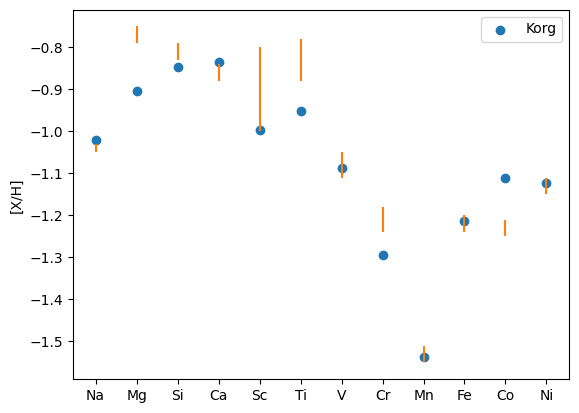

In [13]:
# The are the [X/H] values from the paper (and the errors inferred from Monte-Carlo)
griffith_X_H = [-1.04, -0.77, -0.81, -0.86, -0.9, -0.83, -1.08, -1.21, -1.53, -1.22, -1.23, -1.13]
griffith_X_H_err = [0.01, 0.02, 0.02, 0.02, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02]

scatter(1:length(elements), Korg_abunds, label="Korg")
errorbar(1:length(elements), griffith_X_H, yerr=griffith_X_H_err, ls="", c="C1")
xticks(1:length(elements), elements)
ylabel("[X/H]")
legend()
;